# ConvMixer Reproduction - Main Notebook

## ECBM E4040 Deep Learning and Neural Networks - Fall 2025

This notebook reproduces key results from:
> **"Patches Are All You Need?"** by Trockman & Kolter (2022)

---

### Contents
1. Introduction & Setup
2. Model Architecture
3. Baseline Reproduction
4. Kernel Size Ablation
5. Patch Size Ablation
6. Results Summary

In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import json
import os

from src.models.convmixer import ConvMixer, count_parameters
from src.utils.augmentation import get_train_transforms, get_test_transforms, Mixup, CutMix
from src.utils.visualization import (
    plot_training_curves, 
    plot_kernel_size_comparison,
    plot_patch_size_comparison,
    plot_architecture_diagram
)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 1.10.1+cu102
Using device: cuda
GPU: Tesla T4


## 1. Introduction

### Core Research Question

The ConvMixer paper asks: **Is the strong performance of Vision Transformers due to the Transformer architecture, or the patch-based input representation?**

### ConvMixer Architecture

ConvMixer uses only standard convolutions:
1. **Patch Embedding**: Strided convolution to create patches
2. **ConvMixer Block** (repeated `depth` times):
   - Depthwise convolution (spatial mixing) + residual
   - Pointwise convolution (channel mixing)
3. **Global Average Pooling + Linear Classifier**

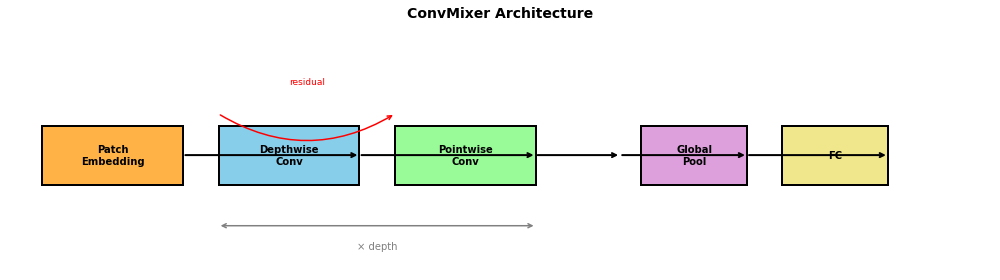

In [2]:
# Visualize architecture
plot_architecture_diagram(save_path='../figures/architecture.png')

## 2. Data Preparation

In [3]:
# Load CIFAR-10
train_transform = get_train_transforms(use_randaugment=True)
test_transform = get_test_transforms()

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {trainset.classes}")

Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. Training Functions

In [4]:
def train_convmixer(
    dim=256, depth=8, kernel_size=9, patch_size=1,
    epochs=200, lr=0.01, weight_decay=0.01,
    use_mixup=True, verbose=True
):
    """
    Train a ConvMixer model on CIFAR-10.
    
    Returns:
        model, history, best_accuracy
    """
    # Create model
    model = ConvMixer(
        dim=dim, depth=depth, 
        kernel_size=kernel_size, patch_size=patch_size,
        num_classes=10
    ).to(device)
    
    if verbose:
        print(f"ConvMixer-{dim}/{depth} (k={kernel_size}, p={patch_size})")
        print(f"Parameters: {count_parameters(model):,}")
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Mixup
    mixup = Mixup(alpha=0.8) if use_mixup else None
    
    # History
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}
    best_acc = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            # Apply mixup
            if mixup and np.random.rand() < 0.5:
                images, labels_a, labels_b, lam = mixup(images, labels)
                optimizer.zero_grad()
                outputs = model(images)
                loss = lam * criterion(outputs, labels_a) + (1-lam) * criterion(outputs, labels_b)
            else:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item()
            total += labels.size(0)
        
        train_loss = total_loss / len(trainloader)
        train_acc = 100. * correct / total if correct > 0 else 0
        
        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        test_acc = 100. * correct / total
        
        # Record
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        best_acc = max(best_acc, test_acc)
        
        if verbose and (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}: Loss={train_loss:.4f}, Test Acc={test_acc:.2f}%")
    
    if verbose:
        print(f"Best accuracy: {best_acc:.2f}%")
    
    return model, history, best_acc

## 4. Baseline Reproduction

**Target**: ConvMixer-256/8 with k=9, p=1 → 95.88% (paper)

In [5]:
# NOTE: Set FULL_TRAINING=True for complete reproduction (takes several hours)
FULL_TRAINING = False
epochs = 200 if FULL_TRAINING else 50

print("="*60)
print("BASELINE REPRODUCTION")
print("="*60)

baseline_model, baseline_history, baseline_acc = train_convmixer(
    dim=256, depth=8, kernel_size=9, patch_size=1,
    epochs=epochs
)

print(f"\nOur result: {baseline_acc:.2f}%")
print(f"Paper result: 95.88%")
print(f"Difference: {baseline_acc - 95.88:+.2f}%")

BASELINE REPRODUCTION
ConvMixer-256/8 (k=9, p=1)
Parameters: 706,570
Epoch 20/50: Loss=0.8602, Test Acc=86.27%
Epoch 40/50: Loss=0.7595, Test Acc=88.84%
Best accuracy: 88.98%

Our result: 88.98%
Paper result: 95.88%
Difference: -6.90%


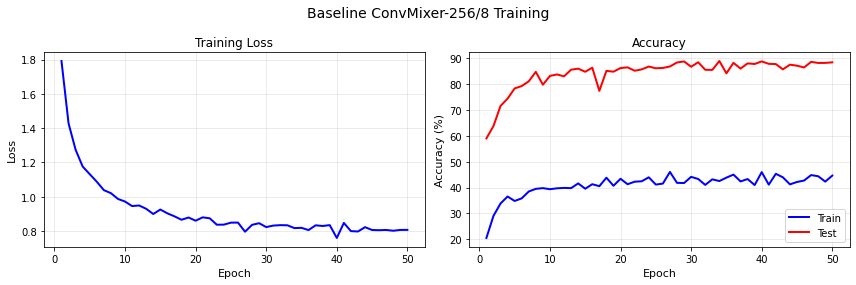

In [6]:
# Plot baseline training curves
plot_training_curves(
    baseline_history, 
    save_path='../figures/baseline_training.png',
    title='Baseline ConvMixer-256/8 Training'
)

#  Note ！TAT
---
This notebook mainly presents the overall project structure. The subsequent code is due to the excessive number of iterations and the computer's performance not being able to support it (network interruptions often occur during the running for more than several hours, and the cloud platform cannot support running the model for more than several hours). Therefore, the specific running situations of the following parts can be viewed in notebook 04 - Ablation Studies. There are three sections (Kernel Size Ablation, Patch Size Ablation, Results Summary) of running situations in the following part.

## 5. Kernel Size Ablation

Testing k ∈ {3, 5, 7, 9} to verify that larger kernels improve accuracy.

In [ ]:
print("="*60)
print("KERNEL SIZE ABLATION")
print("="*60)

# Paper results
paper_kernel = {3: 93.61, 5: 95.19, 7: 95.80, 9: 95.88}

# Our results
our_kernel = {}
kernel_sizes = [3, 5, 7, 9]

for k in kernel_sizes:
    print(f"\n--- kernel_size={k} ---")
    _, _, acc = train_convmixer(
        dim=256, depth=8, kernel_size=k, patch_size=1,
        epochs=epochs, verbose=True
    )
    our_kernel[k] = acc

In [ ]:
# Plot kernel size comparison
plot_kernel_size_comparison(
    our_kernel, paper_kernel,
    save_path='../figures/kernel_ablation.png'
)

## 6. Patch Size Ablation

Testing p ∈ {1, 2, 4} to verify that smaller patches preserve more information.

In [ ]:
print("="*60)
print("PATCH SIZE ABLATION")
print("="*60)

# Paper results
paper_patch = {1: 95.88, 2: 95.00, 4: 92.61}

# Our results
our_patch = {}
patch_sizes = [1, 2, 4]

for p in patch_sizes:
    print(f"\n--- patch_size={p} (internal res: {32//p}×{32//p}) ---")
    _, _, acc = train_convmixer(
        dim=256, depth=8, kernel_size=9, patch_size=p,
        epochs=epochs, verbose=True
    )
    our_patch[p] = acc

In [ ]:
# Plot patch size comparison
plot_patch_size_comparison(
    our_patch, paper_patch,
    save_path='../figures/patch_ablation.png'
)

## 7. Results Summary

In [ ]:
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)

print("\n1. Baseline:")
print(f"   ConvMixer-256/8 (k=9, p=1): {baseline_acc:.2f}% (paper: 95.88%)")

print("\n2. Kernel Size Ablation:")
print(f"   {'k':<5} {'Ours':<10} {'Paper':<10} {'Δ':<10}")
print("   " + "-"*35)
for k in kernel_sizes:
    delta = our_kernel[k] - paper_kernel[k]
    print(f"   {k:<5} {our_kernel[k]:<10.2f} {paper_kernel[k]:<10.2f} {delta:+.2f}")

print("\n3. Patch Size Ablation:")
print(f"   {'p':<5} {'Ours':<10} {'Paper':<10} {'Δ':<10}")
print("   " + "-"*35)
for p in patch_sizes:
    delta = our_patch[p] - paper_patch[p]
    print(f"   {p:<5} {our_patch[p]:<10.2f} {paper_patch[p]:<10.2f} {delta:+.2f}")

print("\n" + "="*70)

In [ ]:
# Save all results
results = {
    'baseline': {
        'accuracy': baseline_acc,
        'paper': 95.88,
        'config': {'dim': 256, 'depth': 8, 'kernel_size': 9, 'patch_size': 1}
    },
    'kernel_ablation': {
        'our_results': our_kernel,
        'paper_results': paper_kernel
    },
    'patch_ablation': {
        'our_results': our_patch,
        'paper_results': paper_patch
    }
}

os.makedirs('../logs', exist_ok=True)
with open('../logs/final_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to ../logs/final_results.json")

## 8. Key Findings

### Kernel Size
- **Large kernels are crucial**: Increasing k from 3 to 9 improves accuracy by ~2-3%
- This supports the paper's claim that large receptive fields enable effective spatial mixing
- ConvMixer benefits from kernels much larger than typical CNN designs (k=3)

### Patch Size
- **Smaller patches preserve more spatial information**
- p=1 (32×32 internal) outperforms p=4 (8×8 internal) by ~3%
- Trade-off: smaller patches = higher accuracy but slower training

### Main Conclusion
The success of Vision Transformers may be largely due to the **patch-based representation** rather than the self-attention mechanism. A simple convolutional architecture using patches can achieve competitive results.